# Clasificación de Dígitos MNIST con Features Cuánticos xFRQI

Este notebook implementa un pipeline completo para:
1. **Extracción de features cuánticos** usando el modelo xFRQI
2. **Clasificación** con SVM y MLP
3. **Visualización** de resultados y análisis de importancia de features

---

## Estructura del Notebook

1. [Configuración e Imports](#1-configuración-e-imports)
2. [Carga y Preparación de Datos](#2-carga-y-preparación-de-datos)
3. [Extracción de Features Cuánticos](#3-extracción-de-features-cuánticos)
4. [Clasificación con SVM](#4-clasificación-con-svm)
5. [Clasificación con MLP](#5-clasificación-con-mlp)
6. [Análisis de Importancia de Features](#6-análisis-de-importancia-de-features)
7. [Visualizaciones t-SNE y PCA](#7-visualizaciones-t-sne-y-pca)

---

## 1. Configuración e Imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configurar path del proyecto
project_root = os.path.dirname(os.getcwd()) if "notebooks" in os.getcwd() else os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"📂 Proyecto cargado desde: {project_root}")

# Crear directorio para resultados
RESULTS_DIR = Path(project_root) / "results" / "features"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"📁 Directorio de resultados: {RESULTS_DIR}")

📂 Proyecto cargado desde: c:\Users\ometi\Documents\IA\Github\FRQI_project
📁 Directorio de resultados: c:\Users\ometi\Documents\IA\Github\FRQI_project\results\features


In [2]:
# Imports del proyecto xFRQI
from src import FRQI2, select_frqi

# Imports de utilidades para features cuánticos
from src.quantum_features_utils import (
    FeatureExtractionConfig,
    extract_features_dataset,
    prepare_classification_data,
    save_features,
    load_features,
    get_kernel,
    get_default_kernels,
    plot_feature_maps,
    plot_feature_importance,
    plot_confusion_matrix,
    plot_tsne_embedding,
    plot_pca_variance,
    FEATURE_NAMES_THEORETICAL,
    FEATURE_NAMES_HARDWARE,
    FEATURE_NAMES_PROBS,
)

# Imports de ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print("✅ Imports completados")

✅ Imports completados


## 2. Carga y Preparación de Datos

In [3]:
# Cargar MNIST
from tensorflow.keras.datasets import mnist

(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

print(f"MNIST cargado:")
print(f"  Train: {x_train_full.shape}")
print(f"  Test:  {x_test_full.shape}")

MNIST cargado:
  Train: (60000, 28, 28)
  Test:  (10000, 28, 28)


In [4]:
# ============================================================
# CONFIGURACIÓN DEL EXPERIMENTO
# ============================================================

N_SAMPLES = 100  # Número total de imágenes a procesar
TEST_RATIO = 0.3  # Proporción para test
RANDOM_SEED = 42

# ============================================================

# Combinar train y test para tener más variedad
all_images = np.concatenate([x_train_full, x_test_full], axis=0)
all_labels = np.concatenate([y_train_full, y_test_full], axis=0)

# Seleccionar subset balanceado por clase
np.random.seed(RANDOM_SEED)

# Estrategia: seleccionar 1 imagen por clase para tener representación
selected_indices = []
samples_per_class = max(1, N_SAMPLES // 10)

for digit in range(10):
    class_indices = np.where(all_labels == digit)[0]
    chosen = np.random.choice(class_indices, size=min(samples_per_class, len(class_indices)), replace=False)
    selected_indices.extend(chosen)

# Limitar al número total deseado
selected_indices = selected_indices[:N_SAMPLES]
np.random.shuffle(selected_indices)

images = all_images[selected_indices]
labels = all_labels[selected_indices]

print(f"\n📊 Dataset seleccionado:")
print(f"   Total de imágenes: {len(images)}")
print(f"   Distribución de clases:")
for digit in range(10):
    count = (labels == digit).sum()
    if count > 0:
        print(f"     Dígito {digit}: {count}")


📊 Dataset seleccionado:
   Total de imágenes: 100
   Distribución de clases:
     Dígito 0: 10
     Dígito 1: 10
     Dígito 2: 10
     Dígito 3: 10
     Dígito 4: 10
     Dígito 5: 10
     Dígito 6: 10
     Dígito 7: 10
     Dígito 8: 10
     Dígito 9: 10


In [5]:
# Split train/test
X_images_train, X_images_test, y_train, y_test = train_test_split(
    images, labels, 
    test_size=TEST_RATIO, 
    random_state=RANDOM_SEED,
    stratify=labels if len(np.unique(labels)) > 1 else None
)

print(f"\n📊 Split de datos:")
print(f"   Train: {len(X_images_train)} imágenes")
print(f"   Test:  {len(X_images_test)} imágenes")


📊 Split de datos:
   Train: 70 imágenes
   Test:  30 imágenes


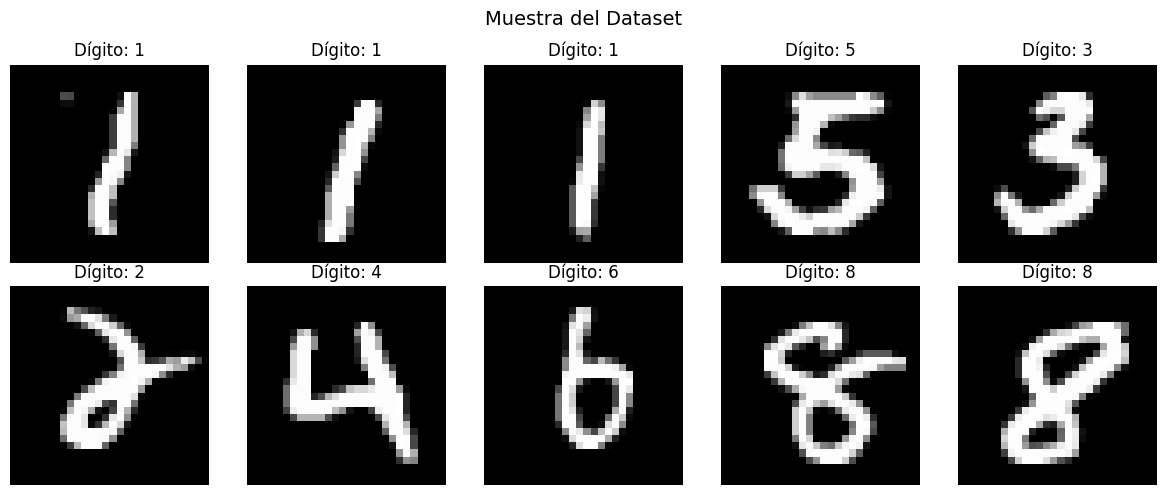

In [6]:
# Visualizar algunas imágenes del dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(images):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Dígito: {labels[i]}")
    ax.axis('off')

plt.suptitle("Muestra del Dataset", fontsize=14)
plt.tight_layout()
plt.show()

## 3. Extracción de Features Cuánticos

Este es el paso más costoso computacionalmente. Para cada imagen:
- Dividimos en ventanas de 4×4 (49 ventanas por imagen)
- Para cada kernel (8 kernels)
- Codificamos imagen+kernel en estado cuántico FRQI2
- Extraemos features teóricos (13) y hardware (3+4)

**Total: N × 8 × 49 = N × 392 codificaciones cuánticas**

In [7]:
# Configuración de extracción
config = FeatureExtractionConfig(
    window_size=4,      # Ventanas de 4×4
    n_windows_x=7,      # 7 ventanas en x (28/4 = 7)
    n_windows_y=7,      # 7 ventanas en y
    kernels=get_default_kernels(),  # 8 kernels
    shots_hardware=1024,  # Shots para features hardware
    device="default.qubit"
)

print("⚙️ Configuración de extracción:")
print(f"   Tamaño de ventana: {config.window_size}×{config.window_size}")
print(f"   Ventanas por imagen: {config.n_windows_x}×{config.n_windows_y} = {config.n_windows_x * config.n_windows_y}")
print(f"   Kernels: {config.kernels}")
print(f"   Shots (hardware): {config.shots_hardware}")
print(f"   Device: {config.device}")

total_encodings = len(images) * len(config.kernels) * config.n_windows_x * config.n_windows_y
print(f"\n   📈 Total de codificaciones: {total_encodings:,}")

⚙️ Configuración de extracción:
   Tamaño de ventana: 4×4
   Ventanas por imagen: 7×7 = 49
   Kernels: ['identity', 'sobel_x', 'sobel_y', 'laplacian', 'gaussian', 'gabor_0', 'gabor_45', 'gabor_90']
   Shots (hardware): 1024
   Device: default.qubit

   📈 Total de codificaciones: 39,200


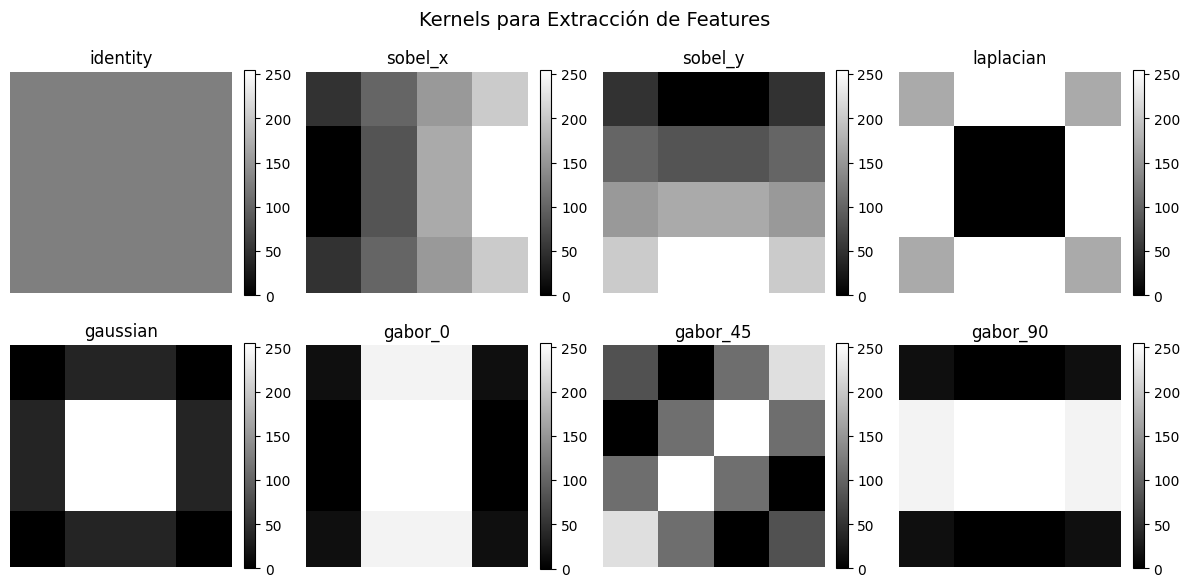

In [8]:
# Visualizar los kernels
kernels = config.kernels
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, (ax, k_name) in enumerate(zip(axes, kernels)):
    kernel = get_kernel(k_name, config.window_size)
    im = ax.imshow(kernel, cmap='gray', vmin=0, vmax=255)
    ax.set_title(k_name)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle("Kernels para Extracción de Features", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# EXTRACCIÓN DE FEATURES (puede tomar varios minutos)
# ============================================================

print("🔄 Extrayendo features cuánticos...")
print("   (Este proceso puede tomar varios minutos)\n")

# Extraer features del dataset completo
features_data = extract_features_dataset(
    images=images,
    labels=labels,
    config=config,
    model_class=FRQI2,
    verbose=True
)

print("\n✅ Extracción completada!")

# Guardar features
features_file = RESULTS_DIR / f"quantum_features_n{N_SAMPLES}.npz"
save_features(features_data, str(features_file))

print(f"💾 Features guardados en: {features_file}")

🔄 Extrayendo features cuánticos...
   (Este proceso puede tomar varios minutos)



Extrayendo features: 100%|██████████| 100/100 [1:01:05<00:00, 36.65s/it]


✅ Extracción completada!


In [9]:
# Cargar features precomputados
features_file = RESULTS_DIR / "quantum_features_n100.npz"
features_data = load_features(str(features_file))

print(f"✅ Cargado: {features_file}")
print(features_data.keys())


✅ Cargado: c:\Users\ometi\Documents\IA\Github\FRQI_project\results\features\quantum_features_n100.npz
dict_keys(['n_images', 'n_kernels', 'n_windows_x', 'n_windows_y', 'window_size', 'kernel_names', 'feature_names_theoretical', 'feature_names_hardware', 'feature_names_probs', 'shots_hardware', 'labels', 'features_theoretical', 'features_hardware_analytic', 'features_hardware_sampled', 'features_probs'])


In [11]:
# Resumen de features extraídos
print("📊 Resumen de features extraídos:")
print(f"   Imágenes procesadas: {features_data['n_images']}")
print(f"   Kernels: {features_data['n_kernels']}")
print(f"   Ventanas: {features_data['n_windows_x']}×{features_data['n_windows_y']}")
print(f"\n   Shapes de arrays:")
print(f"     - Teóricos: {features_data['features_theoretical'].shape}")
print(f"     - Hardware (analítico): {features_data['features_hardware_analytic'].shape}")
print(f"     - Hardware (muestreo): {features_data['features_hardware_sampled'].shape}")
print(f"     - Probabilidades: {features_data['features_probs'].shape}")

📊 Resumen de features extraídos:
   Imágenes procesadas: 100
   Kernels: 8
   Ventanas: 7×7

   Shapes de arrays:
     - Teóricos: (100, 8, 7, 7, 13)
     - Hardware (analítico): (100, 8, 7, 7, 3)
     - Hardware (muestreo): (100, 8, 7, 7, 3)
     - Probabilidades: (100, 8, 7, 7, 4)


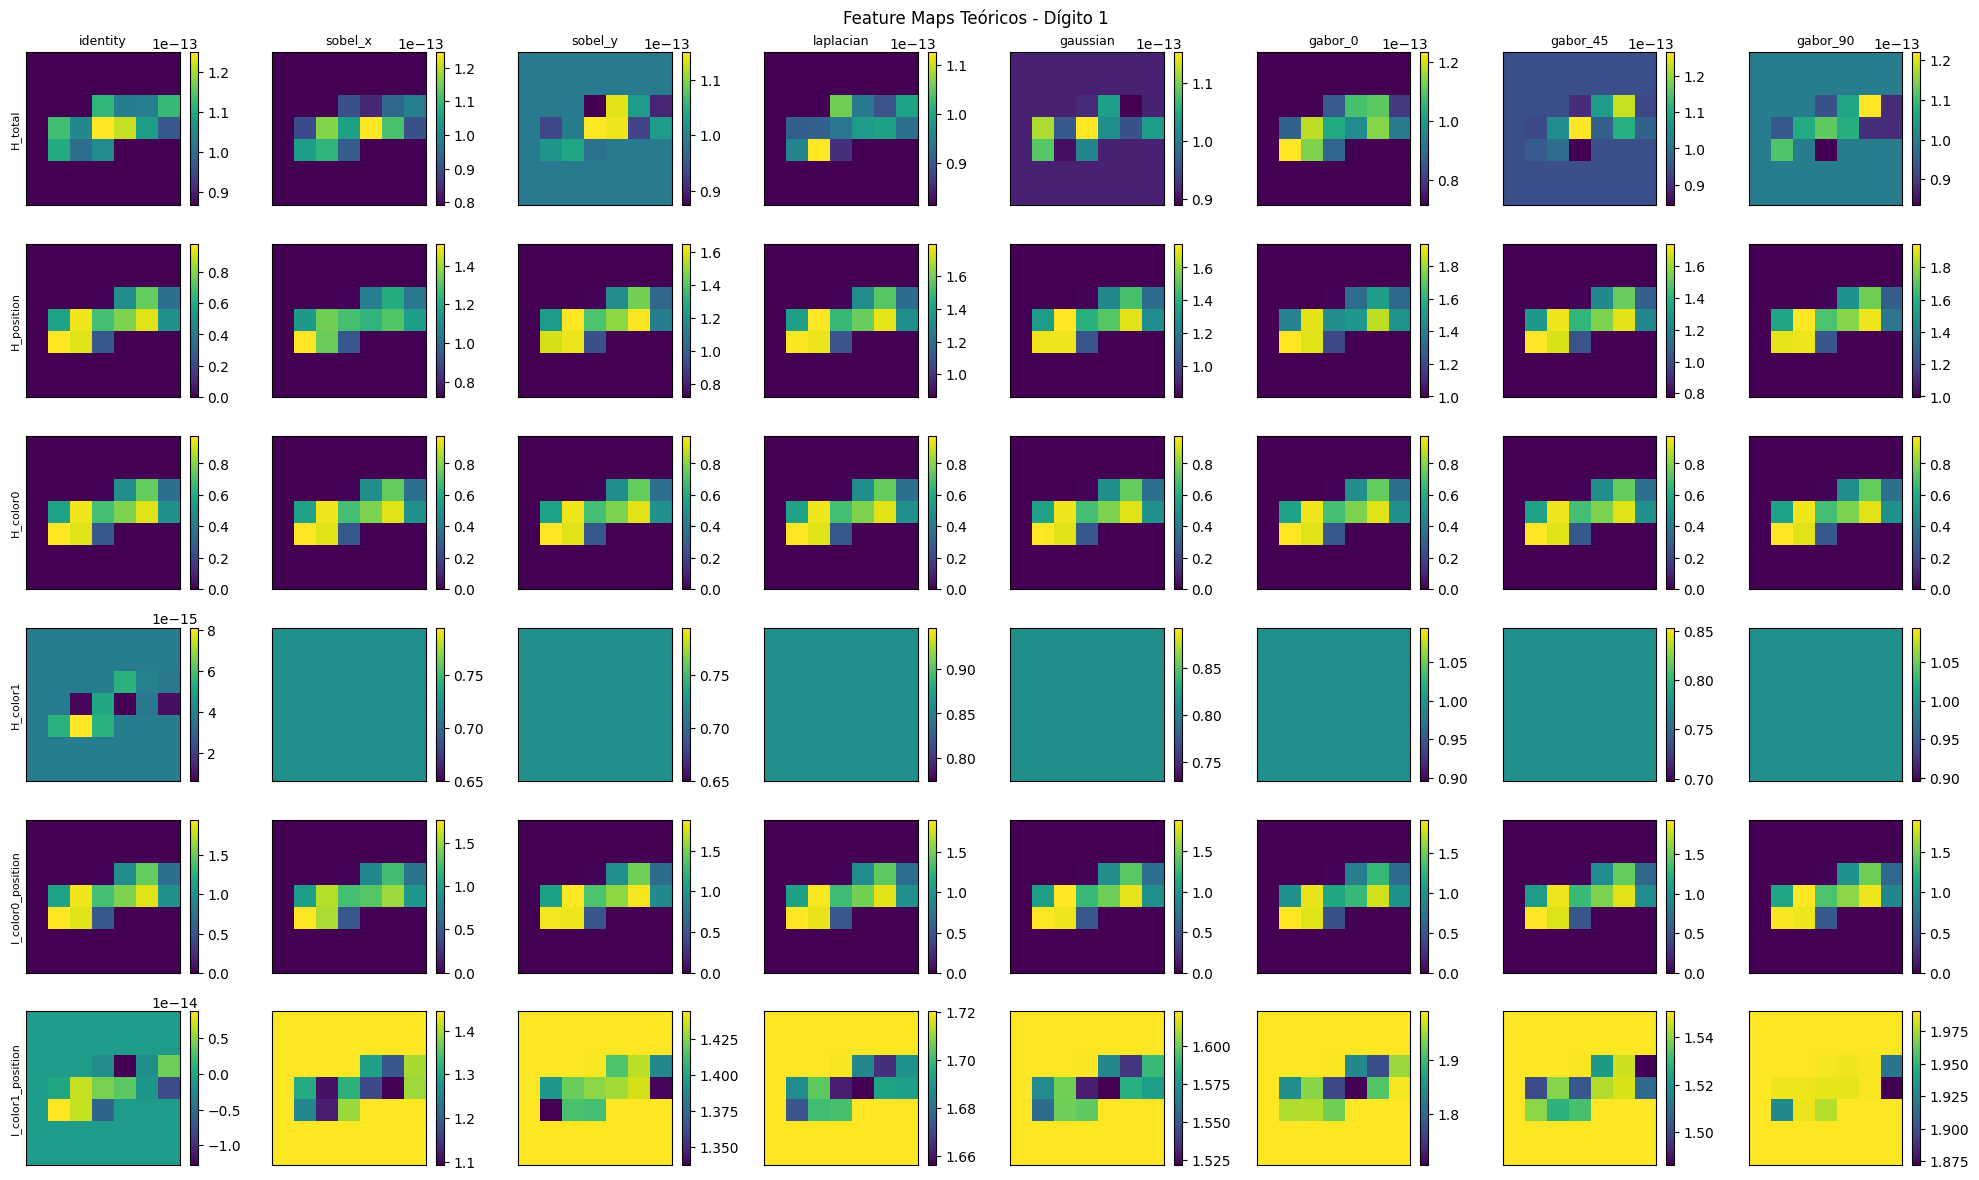

In [12]:
# Visualizar feature maps de una imagen de ejemplo
example_idx = 1
example_features = features_data['features_theoretical'][example_idx]

fig = plot_feature_maps(
    features=example_features,
    feature_names=FEATURE_NAMES_THEORETICAL[:6],
    kernel_names=config.kernels,
    title=f"Feature Maps Teóricos - Dígito {labels[example_idx]}",
    figsize=(20, 12)
)
plt.show()

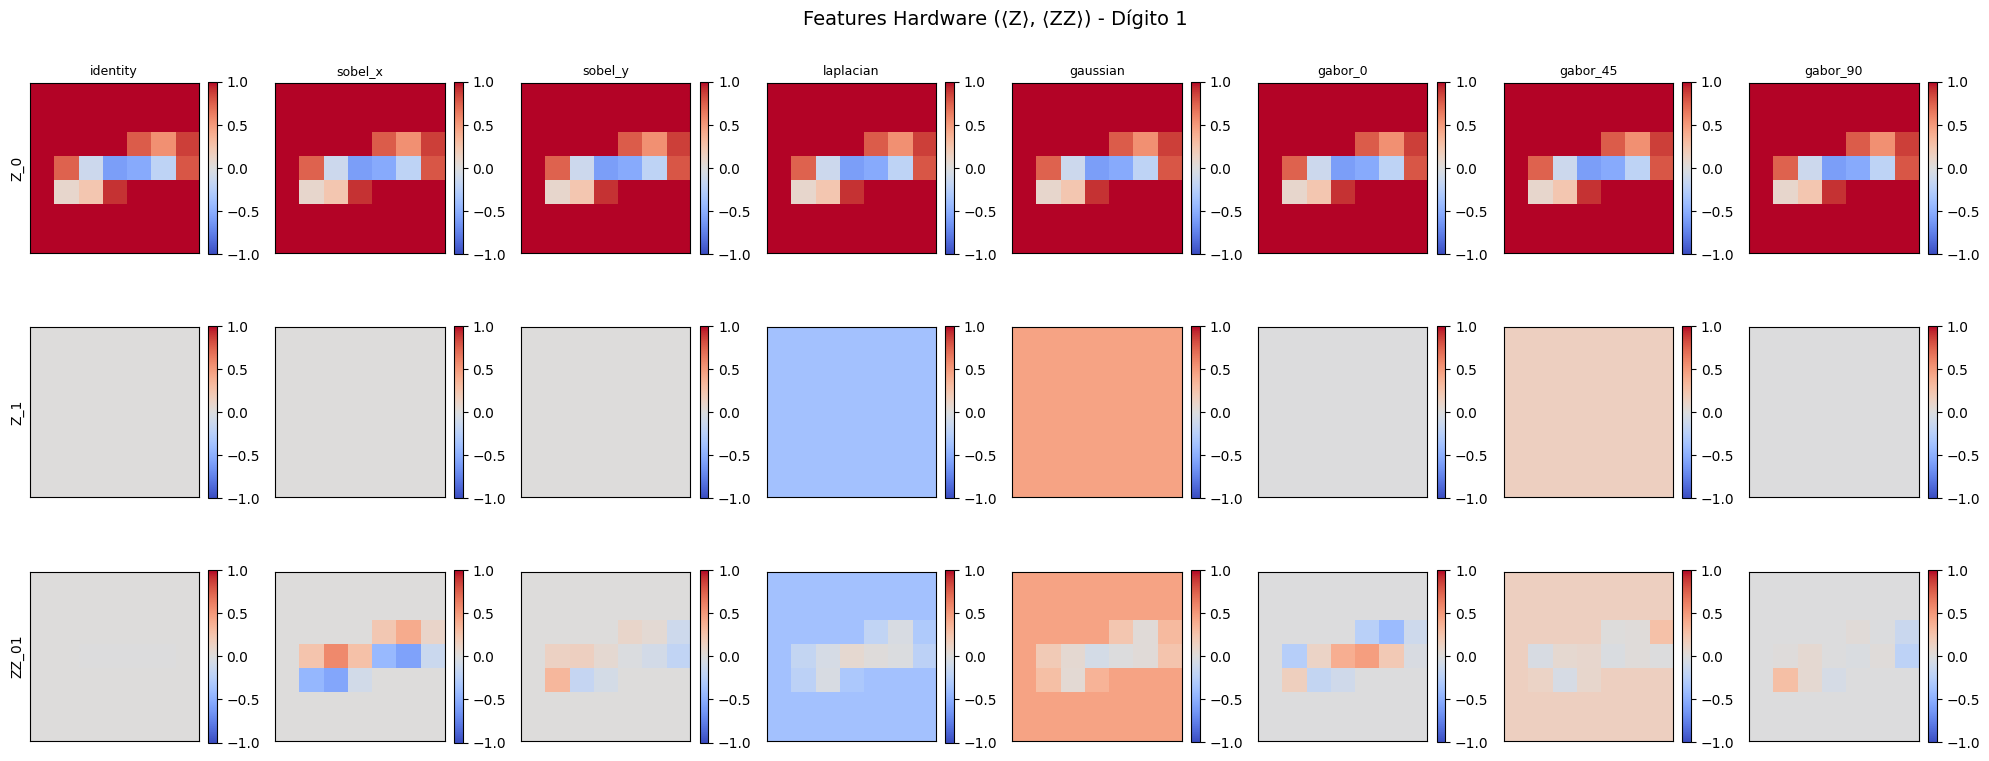

In [13]:
# Visualizar features hardware
example_hw_features = features_data['features_hardware_analytic'][example_idx]

fig, axes = plt.subplots(3, len(config.kernels), figsize=(20, 8))

for f_idx, f_name in enumerate(FEATURE_NAMES_HARDWARE):
    for k_idx, k_name in enumerate(config.kernels):
        ax = axes[f_idx, k_idx]
        im = ax.imshow(example_hw_features[k_idx, :, :, f_idx], 
                       cmap='coolwarm', vmin=-1, vmax=1)
        if f_idx == 0:
            ax.set_title(k_name, fontsize=9)
        if k_idx == 0:
            ax.set_ylabel(f_name, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle(f"Features Hardware (⟨Z⟩, ⟨ZZ⟩) - Dígito {labels[example_idx]}", fontsize=14)
plt.tight_layout()
plt.show()

## 4. Clasificación con SVM

Probamos diferentes combinaciones de features:
- Solo features teóricos
- Solo features hardware (analíticos)
- Solo features hardware (muestreados)
- Todos los features combinados

In [14]:
# Preparar datos para clasificación
def prepare_and_split(features_data, feature_type, test_ratio=TEST_RATIO):
    """
    Prepara y divide datos para clasificación.
    """
    X, y, feature_names = prepare_classification_data(
        features_data, 
        feature_type=feature_type,
        aggregation='stats'
    )
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=RANDOM_SEED,
        stratify=y if len(np.unique(y)) > 1 else None
    )
    
    # Escalar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, feature_names, scaler

In [15]:
# Entrenar y evaluar SVM con diferentes tipos de features
results_svm = {}

feature_types = ['theoretical', 'hardware_analytic', 'hardware_sampled', 'all']

print("="*60)
print("CLASIFICACIÓN SVM")
print("="*60)

for ftype in feature_types:
    print(f"\n▶ Features: {ftype}")
    
    # Preparar datos
    X_train, X_test, y_train, y_test, feat_names, scaler = prepare_and_split(
        features_data, ftype
    )
    
    print(f"  Dimensión de features: {X_train.shape[1]}")
    
    # Entrenar SVM
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=RANDOM_SEED)
    svm.fit(X_train, y_train)
    
    # Evaluar
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    print(f"  Accuracy Train: {acc_train:.4f}")
    print(f"  Accuracy Test:  {acc_test:.4f}")
    
    results_svm[ftype] = {
        'model': svm,
        'acc_train': acc_train,
        'acc_test': acc_test,
        'y_test': y_test,
        'y_pred': y_pred_test,
        'feature_names': feat_names,
        'X_test': X_test,
    }

CLASIFICACIÓN SVM

▶ Features: theoretical
  Dimensión de features: 416
  Accuracy Train: 0.9000
  Accuracy Test:  0.2667

▶ Features: hardware_analytic
  Dimensión de features: 96
  Accuracy Train: 0.8143
  Accuracy Test:  0.2333

▶ Features: hardware_sampled
  Dimensión de features: 96
  Accuracy Train: 0.9857
  Accuracy Test:  0.2000

▶ Features: all
  Dimensión de features: 736
  Accuracy Train: 0.9286
  Accuracy Test:  0.3667


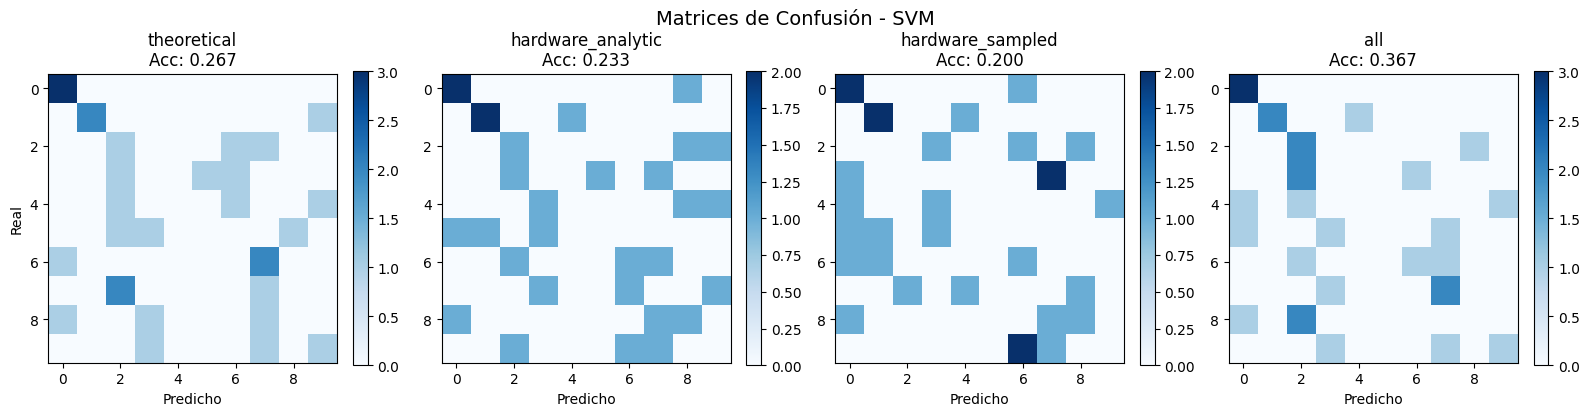

In [16]:
# Visualizar resultados SVM
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (ftype, results) in enumerate(results_svm.items()):
    ax = axes[i]
    
    # Matriz de confusión simplificada
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(results['y_test'], results['y_pred'])
    
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(f"{ftype}\nAcc: {results['acc_test']:.3f}")
    ax.set_xlabel('Predicho')
    if i == 0:
        ax.set_ylabel('Real')
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle("Matrices de Confusión - SVM", fontsize=14)
plt.tight_layout()
plt.show()

## 5. Clasificación con MLP

Red neuronal multicapa para comparar con SVM.

In [17]:
# Entrenar y evaluar MLP con diferentes tipos de features
results_mlp = {}

print("="*60)
print("CLASIFICACIÓN MLP")
print("="*60)

for ftype in feature_types:
    print(f"\n▶ Features: {ftype}")
    
    # Preparar datos
    X_train, X_test, y_train, y_test, feat_names, scaler = prepare_and_split(
        features_data, ftype
    )
    
    print(f"  Dimensión de features: {X_train.shape[1]}")
    
    # Entrenar MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        max_iter=500,
        random_state=RANDOM_SEED,
        early_stopping=True,
        validation_fraction=0.2
    )
    mlp.fit(X_train, y_train)
    
    # Evaluar
    y_pred_train = mlp.predict(X_train)
    y_pred_test = mlp.predict(X_test)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    print(f"  Accuracy Train: {acc_train:.4f}")
    print(f"  Accuracy Test:  {acc_test:.4f}")
    
    results_mlp[ftype] = {
        'model': mlp,
        'acc_train': acc_train,
        'acc_test': acc_test,
        'y_test': y_test,
        'y_pred': y_pred_test,
        'feature_names': feat_names,
        'X_test': X_test,
    }

CLASIFICACIÓN MLP

▶ Features: theoretical
  Dimensión de features: 416
  Accuracy Train: 0.2714
  Accuracy Test:  0.2000

▶ Features: hardware_analytic
  Dimensión de features: 96
  Accuracy Train: 0.1143
  Accuracy Test:  0.2000

▶ Features: hardware_sampled
  Dimensión de features: 96
  Accuracy Train: 0.2000
  Accuracy Test:  0.1000

▶ Features: all
  Dimensión de features: 736
  Accuracy Train: 0.8857
  Accuracy Test:  0.2000


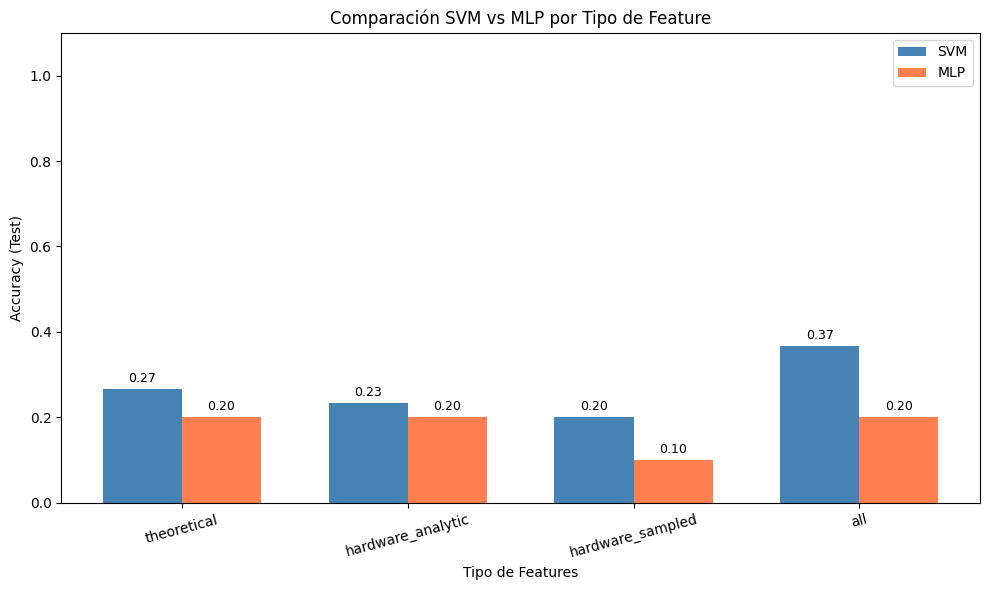

In [18]:
# Comparación SVM vs MLP
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(feature_types))
width = 0.35

acc_svm = [results_svm[ft]['acc_test'] for ft in feature_types]
acc_mlp = [results_mlp[ft]['acc_test'] for ft in feature_types]

bars1 = ax.bar(x - width/2, acc_svm, width, label='SVM', color='steelblue')
bars2 = ax.bar(x + width/2, acc_mlp, width, label='MLP', color='coral')

ax.set_xlabel('Tipo de Features')
ax.set_ylabel('Accuracy (Test)')
ax.set_title('Comparación SVM vs MLP por Tipo de Feature')
ax.set_xticks(x)
ax.set_xticklabels(feature_types, rotation=15)
ax.legend()
ax.set_ylim(0, 1.1)

# Añadir valores sobre barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Análisis de Importancia de Features

Usando Random Forest para obtener importancia de cada feature.

In [19]:
# Entrenar Random Forest para análisis de importancia
print("🌲 Entrenando Random Forest para análisis de importancia...")

# Usar todos los features
X_train, X_test, y_train, y_test, feat_names, scaler = prepare_and_split(
    features_data, 'all'
)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf.fit(X_train, y_train)

acc_rf = accuracy_score(y_test, rf.predict(X_test))
print(f"\nRandom Forest Accuracy: {acc_rf:.4f}")

# Obtener importancias
importances = rf.feature_importances_

🌲 Entrenando Random Forest para análisis de importancia...

Random Forest Accuracy: 0.3667


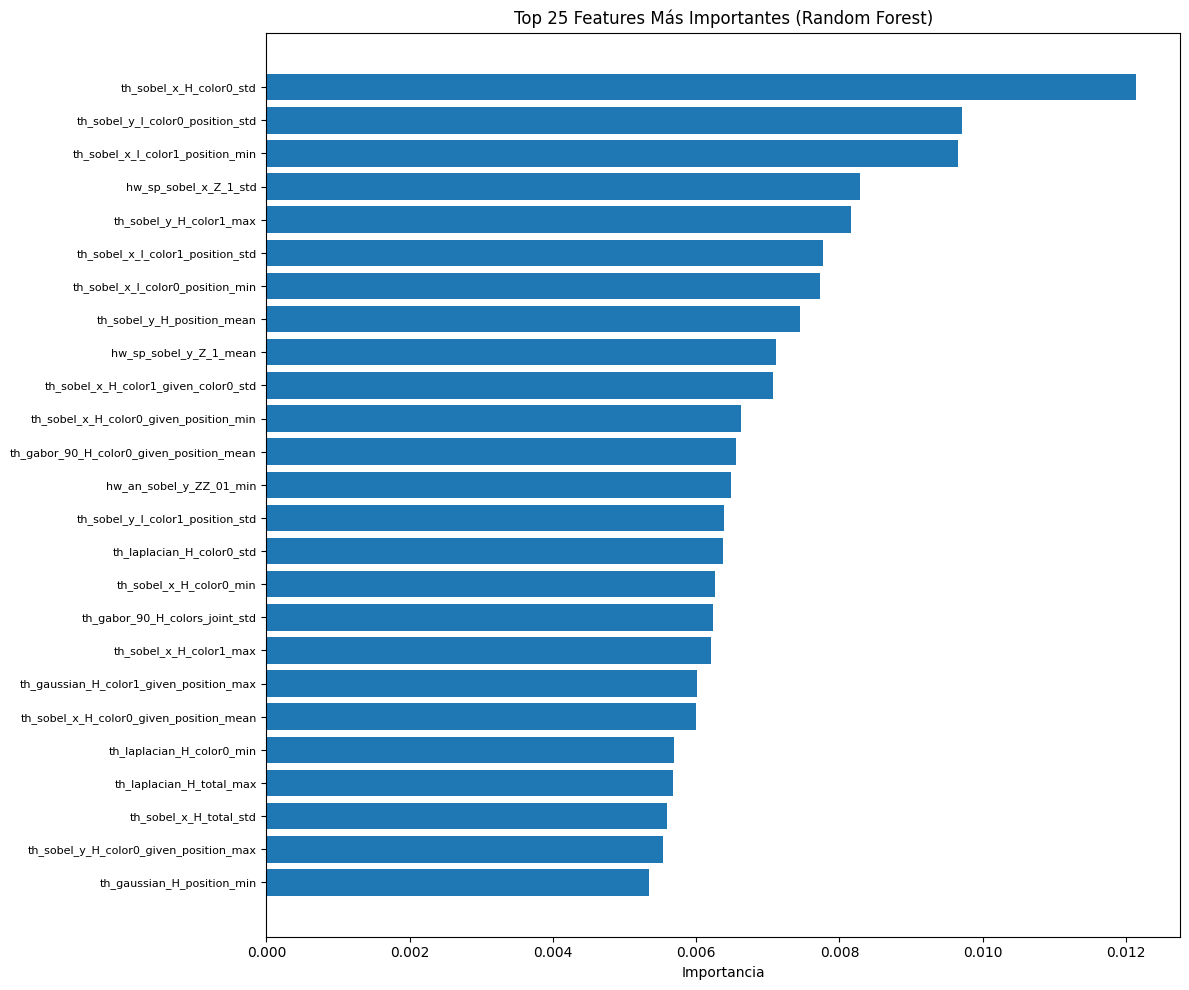

In [21]:
# Visualizar top features
fig = plot_feature_importance(
    importances=importances,
    feature_names=feat_names,
    top_n=25,
    title="Top 25 Features Más Importantes (Random Forest)",
    figsize=(12, 10)
)
plt.show()

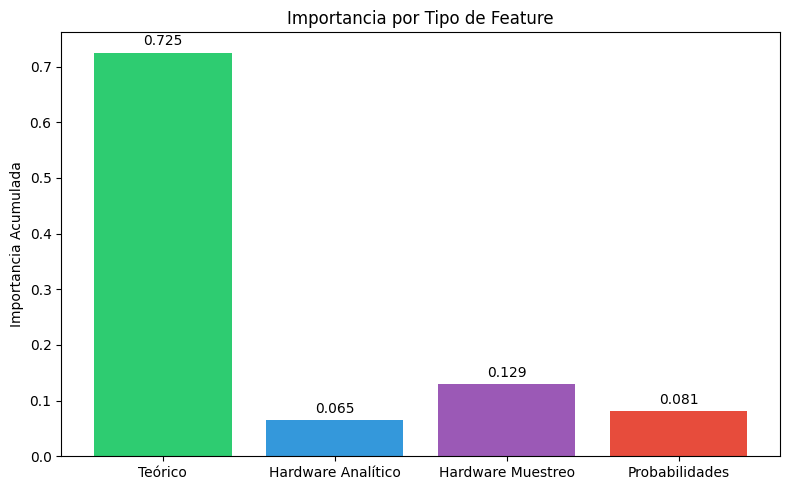

In [22]:
# Análisis por tipo de feature
def categorize_feature(name):
    if name.startswith('th_'):
        return 'Teórico'
    elif name.startswith('hw_an_'):
        return 'Hardware Analítico'
    elif name.startswith('hw_sp_'):
        return 'Hardware Muestreo'
    elif name.startswith('prob_'):
        return 'Probabilidades'
    return 'Otro'

# Agrupar importancias por categoría
category_importance = {}
for name, imp in zip(feat_names, importances):
    cat = categorize_feature(name)
    if cat not in category_importance:
        category_importance[cat] = 0
    category_importance[cat] += imp

# Visualizar
fig, ax = plt.subplots(figsize=(8, 5))

categories = list(category_importance.keys())
values = list(category_importance.values())

colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
bars = ax.bar(categories, values, color=colors[:len(categories)])

ax.set_ylabel('Importancia Acumulada')
ax.set_title('Importancia por Tipo de Feature')

for bar, val in zip(bars, values):
    ax.annotate(f'{val:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, val),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

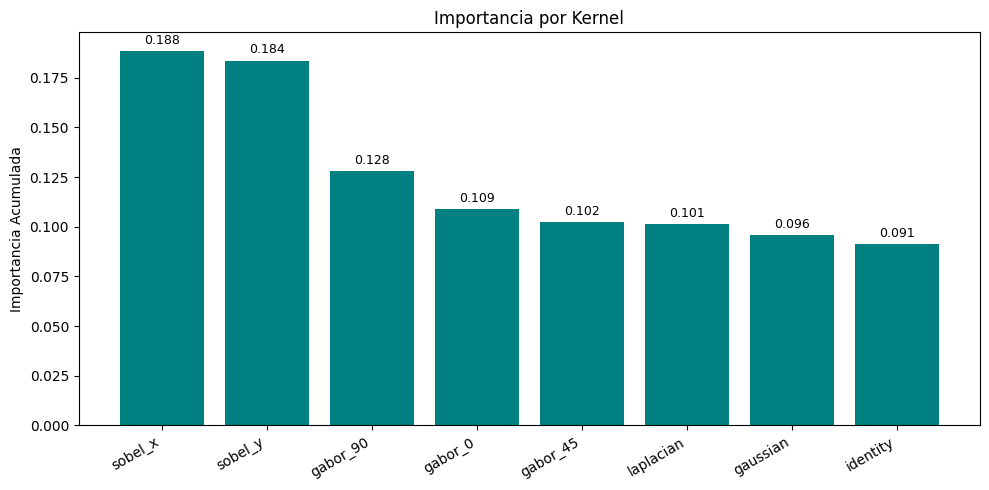

In [23]:
# Análisis por kernel
def extract_kernel_from_name(name):
    parts = name.split('_')
    for k in get_default_kernels():
        if k in name:
            return k
    return 'unknown'

kernel_importance = {k: 0 for k in get_default_kernels()}
for name, imp in zip(feat_names, importances):
    kernel = extract_kernel_from_name(name)
    if kernel in kernel_importance:
        kernel_importance[kernel] += imp

# Visualizar
fig, ax = plt.subplots(figsize=(10, 5))

kernels_sorted = sorted(kernel_importance.items(), key=lambda x: x[1], reverse=True)
k_names = [k[0] for k in kernels_sorted]
k_values = [k[1] for k in kernels_sorted]

bars = ax.bar(k_names, k_values, color='teal')
ax.set_ylabel('Importancia Acumulada')
ax.set_title('Importancia por Kernel')
ax.set_xticklabels(k_names, rotation=30, ha='right')

for bar, val in zip(bars, k_values):
    ax.annotate(f'{val:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, val),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 7. Visualizaciones t-SNE y PCA

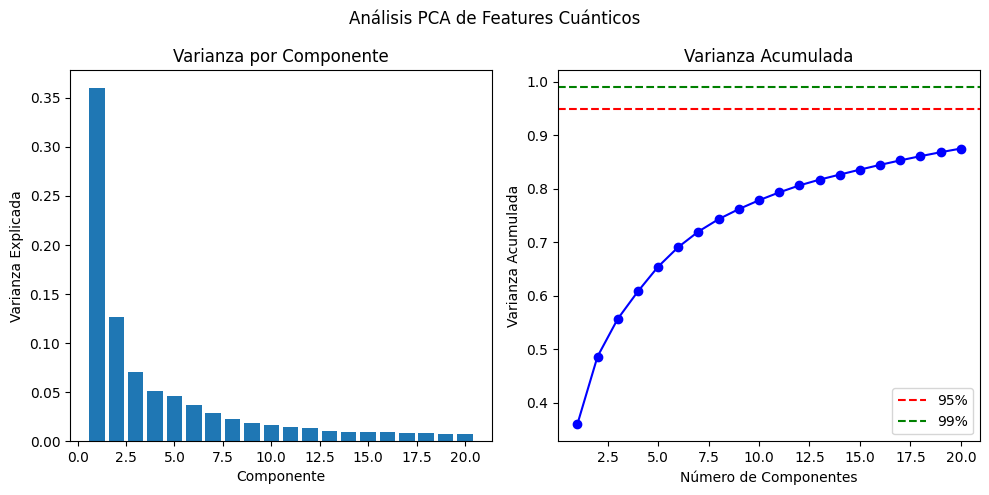

In [24]:
# PCA - Varianza explicada
fig = plot_pca_variance(
    X=X_train,
    n_components=min(20, X_train.shape[1]),
    title="Análisis PCA de Features Cuánticos"
)
plt.show()

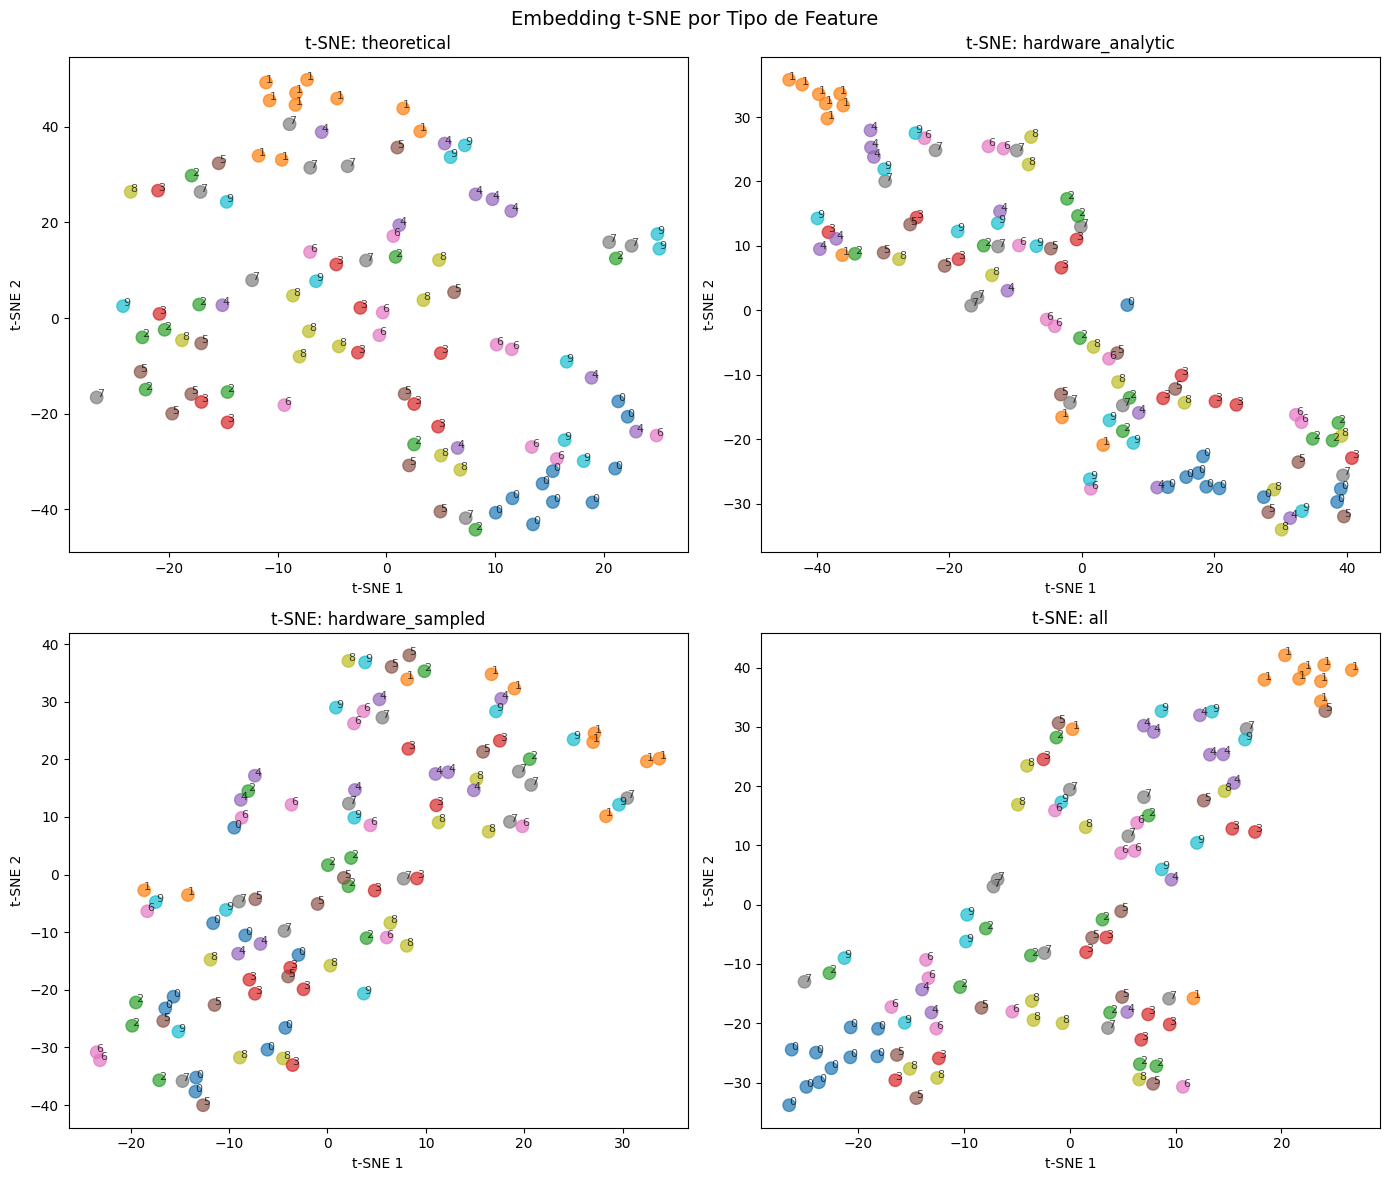

In [25]:
# t-SNE para cada tipo de feature
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, ftype in enumerate(feature_types):
    X_all, y_all, _ = prepare_classification_data(
        features_data, 
        feature_type=ftype,
        aggregation='stats'
    )
    
    # Escalar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_all)
    
    # t-SNE (reducir primero con PCA si hay muchos features)
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    if X_scaled.shape[1] > 50:
        pca = PCA(n_components=min(50, X_scaled.shape[0]-1))
        X_reduced = pca.fit_transform(X_scaled)
    else:
        X_reduced = X_scaled
    
    perplexity = min(5, len(X_reduced) - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=RANDOM_SEED)
    X_embedded = tsne.fit_transform(X_reduced)
    
    # Plot
    ax = axes[i]
    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], 
                         c=y_all, cmap='tab10', alpha=0.7, s=80)
    ax.set_title(f't-SNE: {ftype}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    
    # Añadir etiquetas
    for j in range(len(X_embedded)):
        ax.annotate(str(int(y_all[j])), 
                   (X_embedded[j, 0], X_embedded[j, 1]),
                   fontsize=8, alpha=0.7)

plt.suptitle('Embedding t-SNE por Tipo de Feature', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Resumen de Resultados

In [26]:
# Tabla resumen
print("="*70)
print("RESUMEN DE RESULTADOS")
print("="*70)
print(f"\nDataset: {N_SAMPLES} imágenes MNIST (dígitos 0-9)")
print(f"Configuración: ventanas {config.window_size}×{config.window_size}, {len(config.kernels)} kernels")
print(f"Features totales: {X_train.shape[1]}")
print()
print("-"*70)
print(f"{'Tipo Feature':<25} {'SVM Acc':<12} {'MLP Acc':<12} {'RF Acc':<12}")
print("-"*70)

for ftype in feature_types:
    svm_acc = results_svm[ftype]['acc_test']
    mlp_acc = results_mlp[ftype]['acc_test']
    print(f"{ftype:<25} {svm_acc:<12.4f} {mlp_acc:<12.4f} {'--':<12}")

print("-"*70)
print(f"{'all (Random Forest)':<25} {'--':<12} {'--':<12} {acc_rf:<12.4f}")
print("="*70)

RESUMEN DE RESULTADOS

Dataset: 100 imágenes MNIST (dígitos 0-9)
Configuración: ventanas 4×4, 8 kernels
Features totales: 736

----------------------------------------------------------------------
Tipo Feature              SVM Acc      MLP Acc      RF Acc      
----------------------------------------------------------------------
theoretical               0.2667       0.2000       --          
hardware_analytic         0.2333       0.2000       --          
hardware_sampled          0.2000       0.1000       --          
all                       0.3667       0.2000       --          
----------------------------------------------------------------------
all (Random Forest)       --           --           0.3667      


In [ ]:
# Guardar resultados
results_summary = {
    'config': {
        'n_samples': N_SAMPLES,
        'window_size': config.window_size,
        'n_kernels': len(config.kernels),
        'kernels': config.kernels,
        'shots_hardware': config.shots_hardware,
    },
    'svm_results': {k: {'acc_test': v['acc_test'], 'acc_train': v['acc_train']} 
                   for k, v in results_svm.items()},
    'mlp_results': {k: {'acc_test': v['acc_test'], 'acc_train': v['acc_train']} 
                   for k, v in results_mlp.items()},
    'rf_accuracy': acc_rf,
    'top_features': list(zip(
        [feat_names[i] for i in np.argsort(importances)[::-1][:20]],
        importances[np.argsort(importances)[::-1][:20]].tolist()
    )),
}

import json
results_file = RESULTS_DIR / f"classification_results_n{N_SAMPLES}.json"
with open(results_file, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"📄 Resultados guardados en: {results_file}")

---

## 🎯 Conclusiones

Este notebook demuestra un pipeline funcional para:

1. **Extracción de features cuánticos** usando el modelo xFRQI:
   - Features teóricos (entropías, información mutua)
   - Features hardware-realistas (⟨Z⟩, ⟨ZZ⟩)
   - Probabilidades de medición

2. **Clasificación** con múltiples modelos (SVM, MLP, Random Forest)

3. **Análisis de importancia** para identificar qué features son más relevantes

### Observaciones clave:

- Con N=10 imágenes, los resultados son preliminares y sirven para validar el pipeline
- Para resultados estadísticamente significativos, aumentar N a 1000+
- Los features ⟨ZZ⟩ (correlaciones) capturan información diferente a los individuales ⟨Z⟩

### Próximos pasos:

Ver el documento `QUANTUM_FEATURES_GUIDE.md` para sugerencias de extensión.